In [1]:
!pip install pandas

In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arashnic/fitbit")
path = '/root/.cache/kagglehub/datasets/arashnic/fitbit/versions/2/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16'
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/arashnic/fitbit/versions/2/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16


In [9]:
import pandas as pd
import os

# Use path returned by kagglehub
daily_activity = pd.read_csv(os.path.join(path, "dailyActivity_merged.csv"))
heartrate = pd.read_csv(os.path.join(path, "heartrate_seconds_merged.csv"))
hourly_calories = pd.read_csv(os.path.join(path, "hourlyCalories_merged.csv"))
hourly_intensities = pd.read_csv(os.path.join(path, "hourlyIntensities_merged.csv"))
hourly_steps = pd.read_csv(os.path.join(path, "hourlySteps_merged.csv"))
minute_calories = pd.read_csv(os.path.join(path, "minuteCaloriesNarrow_merged.csv"))
minute_intensities = pd.read_csv(os.path.join(path, "minuteIntensitiesNarrow_merged.csv"))
minute_mets = pd.read_csv(os.path.join(path, "minuteMETsNarrow_merged.csv"))
minute_sleep = pd.read_csv(os.path.join(path, "minuteSleep_merged.csv"))
minute_steps = pd.read_csv(os.path.join(path, "minuteStepsNarrow_merged.csv"))
weight_log = pd.read_csv(os.path.join(path, "weightLogInfo_merged.csv"))


In [22]:
user_id = 1503960366
user_tables = {
    'Daily Activity': daily_activity[daily_activity['Id'] == user_id],
    'Heart Rate': heartrate[heartrate['Id'] == user_id],
    'Hourly Calories': hourly_calories[hourly_calories['Id'] == user_id],
    'Hourly Intensities': hourly_intensities[hourly_intensities['Id'] == user_id],
    'Hourly Steps': hourly_steps[hourly_steps['Id'] == user_id],
    'Minute Calories': minute_calories[minute_calories['Id'] == user_id],
    'Minute Intensities': minute_intensities[minute_intensities['Id'] == user_id],
    'Minute METs': minute_mets[minute_mets['Id'] == user_id],
    'Minute Sleep': minute_sleep[minute_sleep['Id'] == user_id],
    'Minute Steps': minute_steps[minute_steps['Id'] == user_id],
    'Weight Log': weight_log[weight_log['Id'] == user_id],
}


In [40]:
for name, df in user_tables.items():
    print(f"\n=== {name} ===")

    # Check if 'StepTotal' column exists in the current DataFrame
    if 'StepTotal' in df.columns:
        filtered_df = df[df['StepTotal'] != 0]
    else:
        filtered_df = df  # no filtering if no StepTotal column

    display(filtered_df)

<ipython-input-39-1559843146>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['TimeBlock'] = filtered_df['Hour'].apply(get_time_block)


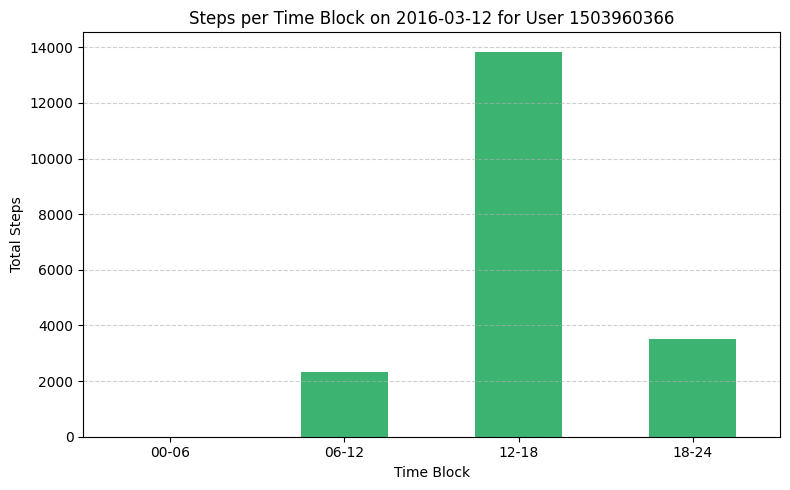

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date

# Step 1: Extract the hourly steps DataFrame for the user
hourly_steps_df = user_tables['Hourly Steps'].copy()

# Step 2: Convert 'ActivityHour' to datetime
hourly_steps_df['ActivityHour'] = pd.to_datetime(hourly_steps_df['ActivityHour'])

# Step 3: Extract 'Date' and 'Hour' from datetime
hourly_steps_df['Date'] = hourly_steps_df['ActivityHour'].dt.date
hourly_steps_df['Hour'] = hourly_steps_df['ActivityHour'].dt.hour

# Step 4: Filter the data for the target date
target_date = date(2016, 3, 12)
filtered_df = hourly_steps_df[hourly_steps_df['Date'] == target_date]

# Step 5: Define time block labels based on hour
def get_time_block(hour):
    if 0 <= hour < 6:
        return '00-06'
    elif 6 <= hour < 12:
        return '06-12'
    elif 12 <= hour < 18:
        return '12-18'
    else:
        return '18-24'

# Step 6: Create a new column for time blocks
filtered_df['TimeBlock'] = filtered_df['Hour'].apply(get_time_block)

# Step 7: Group by TimeBlock and sum steps
steps_by_block = filtered_df.groupby('TimeBlock')['StepTotal'].sum().reindex(['00-06', '06-12', '12-18', '18-24'])

# Step 8: Plot the result
plt.figure(figsize=(8, 5))
steps_by_block.plot(kind='bar', color='mediumseagreen')

plt.title(f'Steps per Time Block on {target_date} for User {user_id}')
plt.xlabel('Time Block')
plt.ylabel('Total Steps')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [4]:
!huggingface-cli login

# ContactDoctor Bio Medical LLM

In [ ]:
!pip install -q transformers accelerate bitsandbytes gradio flash_attn

In [ ]:
import torch
from PIL import Image
import gradio as gr
from transformers import AutoModel, AutoTokenizer, BitsAndBytesConfig
from transformers import AutoModelForCausalLM

# ---- Model Setup ----
model_id = "ContactDoctor/Bio-Medical-Llama-3-8B"

bnb_config = BitsAndBytesConfig( load_in_4bit=True, bnb_4bit_quant_type="nf4",
                                bnb_4bit_use_double_quant=True,
                                bnb_4bit_compute_dtype=torch.float16, )

print("🔄 Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

print("🔄 Loading model...")
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True,
)

# ---- Chat Function ----
def chat_only_interface(message, history):

#the tempelet to receive the prompts
    prompt_template = f"""
  You are a wellbeing adviser. Respond to the user's condition using the following format:

  1. Food Recommendation:
  2. Physical Exercise:
  3. Social Wellbeing Recommendation:
  4. Overall Suggestion:

  User Input: "{message}"
  """
    inputs = tokenizer(prompt_template, return_tensors="pt").to(model.device)

    outputs = model.generate(
        **inputs,
        max_new_tokens=512,
        temperature=0.95,
        do_sample=True,
        top_p=0.9,
        repetition_penalty=1.1,
    )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Trim to just the model's response part
    generated_text = response.split("User Input:")[1] if "User Input:" in response else response

    with open("chat_history.txt", "a", encoding="utf-8") as f:
        f.write(f"User: {message}\n")
        f.write(f"Model: {response}\n\n")

    return generated_text.strip()

# ---- Chat Interface ----
gr.ChatInterface(
    fn=chat_only_interface,
    title="🧠 Bio-Medical LLaMA 3 Chat",
    description="Ask wellness or medical-related questions.",
).queue().launch(debug=True, share=True)

